## Selection of records

In [1]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
sys.path.append('../../lib')
from regimeshifts import ews

In [2]:
data_path = '../../../datasets/bivalve-sclerochronologies/'
md_file = 'chronologies_metadata.csv'
md = pd.read_csv(data_path+md_file, index_col='chronology')

In [3]:
## Removes the records that filtered out high frequency variability
md = md[md.detrend_method.str.contains('lp')!=True]
## Selecting records above 45°N
md = md[md.Southernmost_lat>45]
## Filtering out records with inconsistent AR(1) patters between the different versions.
md = md[md['ar1_handling']!='prewhitening']
## Prioritising the ars version of the records (ARSTAN)
ars_ch = md[md['ar1_handling']=='ars'].index.values
## Otherwise select all versions from the same chronology
nonars_ch = md.groupby(['chron_code']).filter(lambda x: (x['ar1_handling'] != 'ars').all()).index.values
md_sel = md.loc[list(ars_ch)+list(nonars_ch)]
### The literature reports the time interval with highest EPS (>=0.8)
### Here only chronologies with quality intervals greater than 65 years are selected or the whole series
### if the quality interval is not reported in the literature
br_dur = md_sel['similarity_best_range'].str.split('-').apply(lambda x: int(x[1])-int(x[0]) if x[0]!='' else np.nan)
md_sel = md_sel.loc[br_dur[(br_dur>65)|br_dur.isna()].index.values]
md_sel = md_sel[md_sel.Use_allowed!='N'] # Excluding unpublished or duplicated records

In [4]:
rec_l = []
for chron, mdr in md_sel.iterrows():
    best_range = mdr['similarity_best_range'].split('-')
    best_range = [int(x) for x in best_range if x!='']
    if "csv" in mdr.file:
        try:
            df = pd.read_csv(data_path+mdr.file,index_col=0)
            ts = df[mdr['column_name']]    
        except:
            df = pd.read_csv(data_path+mdr.file,sep='[,\t ]', comment='#',index_col=0, engine='python')
    else:
        try:
            df = pd.read_csv(data_path+mdr.file,sep='[,\t ]', comment='#',index_col=0, engine='python')
        except UnicodeDecodeError:
            df = pd.read_csv(data_path+mdr.file,delim_whitespace=True, comment='#',index_col=0, engine='python',encoding='iso-8859-1')
            if df.index.nunique() < len (df.index):
                df = pd.read_csv(data_path+mdr.file,delim_whitespace=True, comment='#',index_col=1, engine='python',encoding='iso-8859-1')
        except:
            df = pd.read_csv(data_path+mdr.file,delim_whitespace=True, comment='#',index_col=0)
    ts = df[mdr['column_name']]    
    ts.rename(chron,inplace=True)
    ts.index = ts.index.astype(int)
    ts.index.name = 'year_ce'
    if len(best_range) == 2:
        ts = ts[(ts.index>=best_range[0])&(ts.index<=best_range[1])]
    ts = ts.loc[ts.first_valid_index():ts.last_valid_index()]
    #rec_l.append(ts.dropna())
    ### Filtering out records that have more than 10% of null values after 1880
    year = 1880
    if len(ts[ts.index>year].dropna())/ (ts[ts.index>year].index.max() - ts[ts.index>year].index.min()) > 0.9:
        if len(ts.dropna()) >= 90: ## Selecting records with at least 100 data points
            rec_l.append(ts.dropna())    
    elif ts.dropna().index.min() <= 1920 - 90: ## Additionally select records with enough data to measure a trend before 1920
        year = 1920 - 90
        if len(ts[(ts.index>year)&(ts.index<=1920)].dropna())/ (ts[(ts.index>year)&(ts.index<=1920)].index.max()\
                                                               - ts[(ts.index>year)&(ts.index<=1920)].index.min()) > 0.9:
            rec_l.append(ts.dropna())
rec = pd.concat(rec_l,axis=1,join='outer')
md_sel = md_sel.loc[rec.columns]

In [5]:
## Selecting only one version from each chronology
selec = {'IS_PB': 'IS_PB_NEars',  ### Choosing the NE version over RCS
         'NIS_PB': 'NIS_PB_NEars', 
         'CNS_BS': 'CNS_BS_LGFraw', ## 
        }  ### Choosing the NE version over RCS
selection = [rec for rec,ch in zip(md_sel.index,md_sel.chron_code) if md_sel.chron_code.value_counts().loc[ch]==1]
selection += selec.values()
rec = rec[selection]
md_sel = md_sel.loc[selection]
rec = rec.sort_index(ascending=True)

In [6]:
print("Number of compiled records: ", md.chron_code.nunique())
print("After applying the selection criteria: ", len(selection))

Number of compiled records:  41
After applying the selection criteria:  25


In [7]:
rec.to_csv('output/sel_records_data.csv') ## Saving the data from the selected records
md_sel.loc[selection].to_csv('output/sel_records_metadata.csv') ## Saving metadata

### Selecting records with data after the year 2000

In [8]:
recent_rec = md_sel.loc[selection][md_sel.loc[selection].latest_year>=2000].index.values
recent_rec_ndata = rec[recent_rec][rec.index>=1920].count()
recent_lr = recent_rec_ndata[recent_rec_ndata>=80].index.values ## Records with at least 80 data points since 1920
recent_rec = rec[recent_lr]

In [9]:
print("Records with at least 80 data points after 1920: ", len(recent_lr))

Records with at least 80 data points after 1920:  21


In [10]:
recent_rec.to_csv('output/sel_recent_rec_data.csv')
md_sel.loc[recent_lr].to_csv('output/sel_recent_rec_metadata.csv') ## Saving metadata

In [11]:
def get_label(rec_id):
    md_id = md_sel.loc[rec_id]
    if 'Pierre' in md_id.Location_name:
        label = md_id.Sea
    else:
        label = md_id.Location_name
    #label = label.replace(' ', '\n')
    info = rec_id.split('_')
    if len(info) > 3 and 'FG' in rec_id:
        label += f' {info[-2]}'
    if info[-1] == 'd18O':
        label += r' $\delta ^{18}O$'
    elif info[-1] == 'd13C':
        label += r' $\delta ^{13}C$'
    ### Particular cases
    if rec_id == 'SPNF_PP_GD':
        label += ' A'
    elif rec_id == 'SPNF_deep_PP_NE':
        label += ' B'
    return label

In [12]:
rec_labels = pd.DataFrame(index=selection)
rec_labels['label'] = selection
rec_labels = rec_labels['label'].apply(lambda x: get_label(x))

In [13]:
rec_labels.to_frame().to_csv('output/sel_rec_labels.csv')

### Selection of long enough records to explore changes in variability over the 20th century

In [14]:
long_recs = md_sel[md_sel.earliest_year<=1920-70].index.values
## Selecting records to measure at least the trend between 1905-1920
long_recs = [r for r in long_recs if len(rec[r][(rec.index>=1840)&(rec.index<=1920)].dropna())>=70]
len(long_recs)

17

In [15]:
rec[long_recs].to_csv('output/sel_long_records_data.csv') ## Saving the data from the selected records
md_sel.loc[long_recs].to_csv('output/sel_long_records_metadata.csv') ## Saving metadata

## Formatted metadata table

In [16]:
def rec_type(row):
    if '18O' in row.name:
        return 'Oxygen isotope'
    elif '13C' in row.name:
        return 'Carbon isotope'
    elif 'PbCa' in row.name:
        return 'Pb/Ca'
    else:
        return 'Shell growth'

In [17]:
def format_coors(row):
    lat = np.round((row['Northernmost_lat']+row['Southernmost_lat'])/2,2)
    lon = np.round((row['Westernmost_lon']+row['Easternmost_lon'])/2,2)
    if lon < 0:
        lon_str = str(abs(lon)) + '°W'
    else:
        lon_str = str(lon) + '°E'
    return str(lat) + '°N, ' + lon_str        

In [18]:
def get_period(row):
    period = str(row['earliest_year']) + '-'+ str(row['latest_year'])
    full_int = rec[row.name].last_valid_index()-rec[row.name].first_valid_index()
    notnull_vals = len(rec[row.name].dropna())
    if notnull_vals < full_int:
        period += '*'
    return period

In [19]:
recs_multid_pattern = ['IS_PB_NEars','TP_DR_NEars','FG_JEM_PAD','SPNF_PP_GD','Faroe_FWB_NEars',                       
                       'FG_PB_B_LCars', 'FG_PB_C_LCars','FG_PB_F5_LCars',
                       'BS_MM_d18O','Norw_HH_RCS','NIS_DR_d18O','NIS_PB_NEars']

In [20]:
records = rec[long_recs]
long_recs_expl = ews.Ews(records[(records.index>=1800)&(records.index<=1920)])
long_recs_ar1 = long_recs_expl.ar1(detrend=True,wL=50,bW=35)
def get_analysed_periods(row):
    periods = ''
    i = 0
    if row.name in recent_rec:
        periods += '1920-'+ str(md_sel.loc[row.name,'latest_year'])
        i = 1
    if row.name in recs_multid_pattern:
        plus = ', ' if i>0 else ''
        periods += plus + str(rec[rec.index>=1800][row.name].first_valid_index()) + '-'+ str(rec[rec.index>=1800][row.name].last_valid_index())
    if row.name in long_recs:
        plus = ', ' if i>0 else ''
        periods += plus + str(long_recs_expl[row.name].first_valid_index()) + '-' + str(long_recs_ar1[row.name].last_valid_index())
    if periods == '':
        periods = 'None'
    return periods

In [21]:
locations = {'TP_DR_NEars': 'Tiree Passage, Hebridean Sea',
             'FG_PB_A_LCars': 'Fladen Ground, North Sea',
             'FG_PB_B_LCars': 'Fladen Ground, North Sea',
             'FG_PB_C_LCars': 'Fladen Ground, North Sea',
             'FG_PB_F1_LCars': 'Fladen Ground, North Sea',
             'FG_PB_F5_LCars': 'Fladen Ground, North Sea',
             'IOME_WB_NEars': 'Isle of Man (East), Irish Sea',
             'Faroe_FWB_NEars': 'Faroe Shelf',
             'Norw_HH_RCS': 'Northeastern North Sea',
             'DB_HH_RCS': 'Doggerbank, North Sea',
             'ENS_HH_RCS': 'Southeastern North Sea',
             'BL_IR': 'Belfast Lough, Irish Sea',
             'EC_SH': 'English Channel',
             'BS_MM_NE': 'Northern Norway',
             'BS_MM_d18O': 'Northern Norway',
             'FG_JEM_PAD': 'Fladen Ground, North Sea',
             'FG_JEM_d13C': 'Fladen Ground, North Sea',
             'NIS_DR_d18O': 'North Icelandic Shelf, Iceland',
             'NIS_DR_d13C': 'North Icelandic Shelf, Iceland',
             'TP_DR_d18O': 'Tiree Passage, Hebridean Sea',
             'TP_DR_d13C': 'Tiree Passage, Hebridean Sea',
             'SPNF_PP_GD': 'Newfoundland Shelf',
             'SPNF_deep_PP_NE': 'Newfoundland Shelf',
             'SNS_BS_Td18O': 'Amrumbank, North Sea',
             'IS_PB_NEars': 'Isle of Man, Irish Sea',
             'NIS_PB_NEars': 'North Icelandic Shelf, Iceland',
             'CNS_BS_LGFraw': 'Central North Sea, North Sea',
             'SWI_MM_HGF': 'Southwest Iceland',
             'SWI_MM_d18O': 'Southwest Iceland'}

In [22]:
table_sel = pd.DataFrame(index=md_sel.index)
table_sel['Record'] = rec_labels
table_sel['Type'] = table_sel.apply(lambda x: rec_type(x),axis=1)
table_sel['Location'] = pd.Series(locations)
table_sel['Coordinates'] = md_sel.apply(lambda x: format_coors(x),axis=1)
table_sel['Species'] = md_sel.Species
table_sel['Depth (m)'] = md_sel['depth_range']
table_sel['Period (years CE)'] = md_sel.apply(lambda x: get_period(x),axis=1)
table_sel['Robust interval'] = md_sel['similarity_best_range']
table_sel['Reference'] = md_sel['Citation']
table_sel['Original publication'] = md_sel['Publication']
table_sel['Examined periods'] = table_sel.apply(lambda x: get_analysed_periods(x),axis=1)

In [23]:
def get_sel_version(row):
    """
    Gets the selected version from each study
    """
    num_versions = md.groupby('chron_code')['study'].count()
    detr_meth = md_sel.loc[row.name].detrend_method
    ars_h = md_sel.loc[row.name].ar1_handling
    if row.name == 'SPNF_PP_GD':
        detr_meth = 'GDOM'
    elif row.name == 'FG_JEM_PAD':
        detr_meth = 'PAD'
    i = 0
    text = ''
    if detr_meth != 'unknown':
        if not isinstance(detr_meth,float):            
            text += str(detr_meth)
            i = 1
    if ars_h != 'unknown':
        if not isinstance(ars_h,float):
            #plus = ' ' if i >0 else ''
            text += str(ars_h)
            i = 1
    if num_versions.loc[md_sel.loc[row.name]['chron_code']] > 1:
        text += ' out of ' + str(num_versions.loc[md_sel.loc[row.name]['chron_code']]) + ' versions. '
        text += 'AR(1) agreement: ' + corrs[md_sel.loc[row.name]['chron_code']] + '.'
    else:
        plus = '. ' if i > 0 else ''
        text += plus + 'Unique version.'
    return text

In [24]:
md = pd.read_csv(data_path+md_file, index_col='chronology')
md = md[md.detrend_method.str.contains('lp')!=True]
md = md[md.Southernmost_lat>45]
md = md[md.Use_allowed!='N'] # Excluding unpublished or duplicated records

In [25]:
all_recs_ls = []
for chron, mdr in md.iterrows():
    best_range = mdr['similarity_best_range'].split('-')
    best_range = [int(x) for x in best_range if x!='']
    if "csv" in mdr.file:
        try:
            df = pd.read_csv(data_path+mdr.file,index_col=0)
            ts = df[mdr['column_name']]    
        except:
            df = pd.read_csv(data_path+mdr.file,sep='[,\t ]', comment='#',index_col=0, engine='python')
    else:
        try:
            df = pd.read_csv(data_path+mdr.file,sep='[,\t ]', comment='#',index_col=0, engine='python')
        except UnicodeDecodeError:
            df = pd.read_csv(data_path+mdr.file,delim_whitespace=True, comment='#',index_col=0, engine='python',encoding='iso-8859-1')
            if df.index.nunique() < len (df.index):
                df = pd.read_csv(data_path+mdr.file,delim_whitespace=True, comment='#',index_col=1, engine='python',encoding='iso-8859-1')
        except:
            df = pd.read_csv(data_path+mdr.file,delim_whitespace=True, comment='#',index_col=0)
    ts = df[mdr['column_name']]    
    ts.rename(chron,inplace=True)
    ts.index = ts.index.astype(int)
    ts.index.name = 'year_ce'
    #if len(best_range) == 2:
    #    ts = ts[(ts.index>=best_range[0])&(ts.index<=best_range[1])]
    ts = ts.loc[ts.first_valid_index():ts.last_valid_index()]
    all_recs_ls.append(ts.dropna())
all_rec = pd.concat(all_recs_ls,axis=1,join='outer')

In [26]:
recs_to_corr = ['FG_PB_B','FG_PB_C','FG_PB_F5','IS_PB', 'NIS_PB','CNS_BS']

corrs = {}
for chid in recs_to_corr:
    text = 'r='
    r2c = ews.Ews(all_rec[md[md['chron_code']==chid].index.values][all_rec.index>=1850])
    r2c_ar1 = r2c.ar1(detrend=True,bW=35,wL=50)
    r_corr = np.unique(np.round(r2c_ar1.corr().values,2))
    r_corr = r_corr[r_corr<1]
    if len(r_corr) == 1:
        text += str(r_corr[0])
    else:
        text += str(np.min(r_corr)) + '-' + str(np.max(r_corr))
    corrs[chid] = text

In [27]:
table_sel['Selected version'] = table_sel.apply(lambda x: get_sel_version(x),axis=1)

In [28]:
## Reading values from the significance test output file
ar1_trends = pd.read_csv('output/pvalues_1920-today.csv',index_col=0)

In [29]:
table_sel['ar1'] = ar1_trends['kc']
table_sel['len_per'] = table_sel['Examined periods'].apply(lambda x: len(x))
table_sel = table_sel.sort_values(by=['len_per','ar1'],ascending=False)
table_sel = table_sel.drop(columns=['ar1','len_per']) ## 
#table_all = table_sel.append(table_not_sel) ## Table including all records

In [30]:
table_sel.to_csv('output/table_sel_rec_md.csv') ## Saving the data from the selected records

### Map with selected records

In [33]:
md_selected_rec = pd.read_csv('output/sel_records_metadata.csv',index_col=0)

In [34]:
def rec_type_c(row):
    if '18O' in row.name:
        return 'oxygen'
    elif '13C' in row.name:
        return 'carbon'
    else:
        return 'growth'
coords = pd.DataFrame(index=md_selected_rec.index)
coords['Latitude'] = (md_selected_rec['Northernmost_lat']+md_selected_rec['Southernmost_lat'])/2
coords['Longitude'] = (md_selected_rec['Westernmost_lon']+md_selected_rec['Easternmost_lon'])/2
coords['type'] = coords.apply(lambda x: rec_type_c(x),axis=1)

In [35]:
def get_new_coors_proj(grouped_coors_row,coords_df,proj, radius=1.5,init_angle=-20,trim_angle=10,full_angle=220):
    """
    Estimates the new coordinates for a group of records with the same coordinates
    Returns the new coordinates in the coordinate system of the received projection
    """
    res_ang = full_angle - (2 * trim_angle) # 
    n_rec = grouped_coors_row['count'] 
    part_angle = res_ang/(n_rec + 1) # Resulting angle after dividing by the number of records
    group_df = coords_df.loc[grouped_coors_row['record']] ## Retrieving dataframe
    proj_cart = ccrs.PlateCarree() ## Cartesian coordinate system
    x,y = proj.transform_point(group_df.Longitude.mean(),group_df.Latitude.mean(),src_crs=proj_cart)
    ## One degree of latitude in the projection coordinates
    one_deg_lat_proj = y - proj.transform_point(group_df.Longitude.mean(),group_df.Latitude.mean()+1,src_crs=proj_cart)[1]
    group_df['x'] = x
    group_df['y'] = y
    y_plus = []
    x_plus = []    
    
    for i in range(1,n_rec+1):        
        y_plus.append(np.sin(np.deg2rad(init_angle + trim_angle + (i*part_angle))) * one_deg_lat_proj*radius)
        x_plus.append(np.cos(np.deg2rad(init_angle + trim_angle + (i*part_angle))) * one_deg_lat_proj*radius)
    group_df.y += y_plus
    group_df.x += x_plus
    return group_df

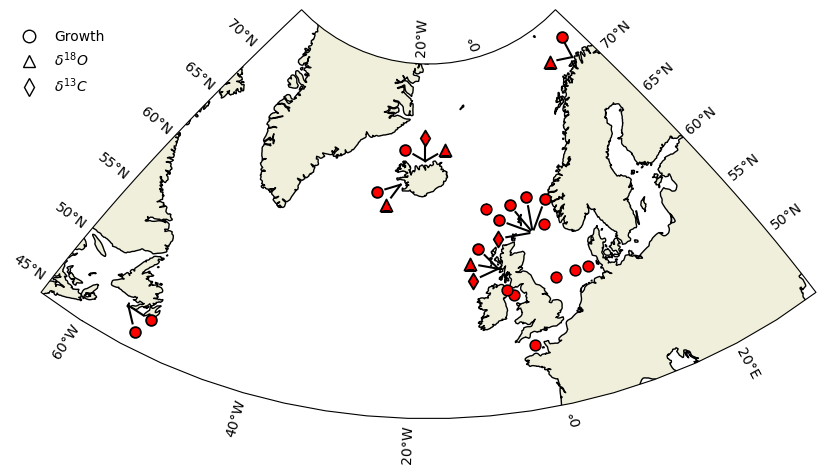

In [36]:
lons = [-65,30]
lats = [44,75]
proj = ccrs.TransverseMercator(central_longitude=lons[0]+(lons[1]-lons[0])/2,
                                   central_latitude=lats[0]+(lats[1]-lats[0])/2)
n = 20
aoi = mpath.Path(
    list(zip(np.linspace(lons[0],lons[1], n), np.full(n, lats[1]))) + \
    list(zip(np.full(n, lons[-1]), np.linspace(lats[1], lats[0], n))) + \
    list(zip(np.linspace(lons[1], lons[0], n), np.full(n, lats[0]))) + \
    list(zip(np.full(n, lons[0]), np.linspace(lats[0], lats[1], n)))
)
plt.close()
fig = plt.figure(figsize=(10,7),facecolor='white')
ax1 = fig.add_subplot(1, 1, 1, projection=proj)
#ax2 = fig.add_subplot(1, 2, 2, projection=proj)

ax1.set_boundary(aoi, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND,zorder=2)
ax1.coastlines(resolution='50m',zorder=2)
gl = ax1.gridlines(draw_labels=True,linewidth=0, linestyle='--',alpha=0.5)
ax1.set_extent([lons[0], lons[1], lats[0], lats[1]])
gl.top_labels = False
gl.right_labels = False

#### Plotting the bivalve records
### Grouping coordinates
for i,(rec_ids,ax) in enumerate(zip([coords.index],[ax1])):
    biv_ews = coords.loc[rec_ids]
    coors_yr_df = biv_ews.reset_index()
    coors_yr_df.rename(columns={'index':'record'}, inplace=True)
    FG_rec = ['FG_PB_A_LCars','FG_PB_C_LCars','FG_PB_F1_LCars','FG_PB_F5_LCars','FG_JEM_PAD','FG_JEM_d13C']
    coors_yr_df.loc[coors_yr_df[coors_yr_df.record.isin(FG_rec)].index,'Latitude'] =\
    coors_yr_df[coors_yr_df.record=='FG_PB_B_LCars']['Latitude'].iloc[0]
    coors_yr_df.loc[coors_yr_df[coors_yr_df.record.isin(FG_rec)].index,'Longitude'] =\
    coors_yr_df[coors_yr_df.record=='FG_PB_B_LCars']['Longitude'].iloc[0]
    coors_yr_gr = coors_yr_df.groupby([coors_yr_df['Latitude'].apply(lambda x: round(x*2)/2),coors_yr_df['Longitude'].apply(lambda x: round(x*2)/2)]).agg(list)
    coors_yr_gr['count'] = coors_yr_gr.record.apply(lambda x: len(x))
    unique_yr_coors = coors_yr_gr[coors_yr_gr['count']==1].record.apply(lambda x: x[0]).values
    yr_unique_coors = biv_ews.loc[unique_yr_coors]    
    markers = {'growth':'o','oxygen':'^','carbon':'d'}
    markersize = {'growth':60,'oxygen':75,'carbon':65}
    markerlabels = {'Growth':'o',r'$\delta ^{18}O$':'^',r'$\delta ^{13}C$':'d'}
    #indicator = 'kc'
    ## Records with repeated coordinates
    initial_angles = {(56.5, -6.5):-90,(59.0, 0.5):0,(59.0, 0.0):-150,(66.5, -18.0):140,
                      (71.0, 24.0):-145,(47.0, -56.5):50,(64.5, -23.0):-30}
    full_angles = {(56.5, -6.5):160,(59.0, 0.5):110,(59.0, 0.0):200,(66.5, -18.0):260,
                   (71.0, 24.0):240,(47.0, -56.5):150,(64.5, -23.0):130}
    radii = {(56.5, -6.5):2.5,(59.0, 0.5):3,(59.0, 0.0):3.2,(66.5, -18.0):2,
             (71.0, 24.0):2.5,(47.0, -56.5):2.5,(64.5, -23.0):2.2}
    origin_radii = {(56.5, -6.5):0,(59.0, 0.5):0.8,(59.0, 0.0):0.3,(66.5, -18.0):0,
                    (71.0, 24.0):0,(47.0, -56.5):0,(64.5, -23.0):0}
    ## Parameters for significant records
    plus_radii = {(56.5, -6.5):3,(59.0, 0.5):2,(59.5, 0.5):2,(66.5, -18.0):2.5,(71.0, 24.0):2.5,(47.0, -56.5):1,(64.5, -23.0):2}
    plus_initangle = {(56.5, -6.5):0,(59.0, 0.5):-30,(59.5, 0.5):-30,(66.5, -18.0):-10,(71.0, 24.0):-7,(47.0, -56.5):0,(64.5, -23.0):0}
    if i == 1:
        selected_gr = coors_yr_gr.loc[[(56.5,-6.5),(66.5,-18.0),(71.0,24.0)]]
        uni = [r for r in yr_unique_coors.index.values if r not in ['TP_DR_d13C','Norw_MM_d18O']]
        yr_unique_coors = yr_unique_coors.loc[uni] 
    else:
        selected_gr = coors_yr_gr[coors_yr_gr['count']>1]
    for idx,row in selected_gr.iterrows():
        if i == 1 and idx in [(71.0, 24.0),(56.5,-6.5)]:
            f_rad = 0.6
        else:
            f_rad = 1
        new_coors = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]*f_rad,init_angle=initial_angles[idx],full_angle=full_angles[idx])
            
        for type_rec,marker in markers.items():
            coors_type = new_coors[new_coors.type==type_rec]
            if len(coors_type) > 0:
                ax.scatter(x=coors_type.x, y=coors_type.y, s=markersize[type_rec],linewidth=1.3, marker=marker,
                       color='red', edgecolors='k',zorder=2)
       ## Lines
        new_coors_lines = get_new_coors_proj(row,biv_ews,proj,radius=radii[idx]*f_rad-0.8,init_angle=initial_angles[idx],full_angle=full_angles[idx])
        new_coors_origin = get_new_coors_proj(row,biv_ews,proj,radius=origin_radii[idx],init_angle=initial_angles[idx],full_angle=full_angles[idx])        
        ax.plot([new_coors_lines.x, new_coors_origin.x], [new_coors_lines.y, new_coors_origin.y],color='k')
    ## Records with unique coordinates
    for type_rec,marker in markers.items():            
        coors_type = yr_unique_coors[yr_unique_coors.type==type_rec]
        #coors_type = coors_type.sort_values(by='kc')
        if len(coors_type) > 0:
            ax.scatter(x=coors_type.Longitude, y=coors_type.Latitude, s=markersize[type_rec],marker=marker,
                       linewidth=1.1,color='red',transform=ccrs.PlateCarree(),
                       edgecolors='k',zorder=2)
        # Legend
    for label,marker in markerlabels.items():
        ax.plot(-180,0,marker=marker,markersize=9,color='white',markeredgecolor='k',transform=ccrs.PlateCarree(),label=label)
    ax.legend(loc=(-0.04,0.68),frameon=False)

fig.savefig(f'img/Location_all_selected_records.png',dpi=300, bbox_inches='tight')
plt.show()